# Tensorflow modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

## 1, Load the data

In [2]:
#from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

df = pd.read_csv(r'E:\FEM\Python\bitbucket\Vattenfall_rnn\vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[0]

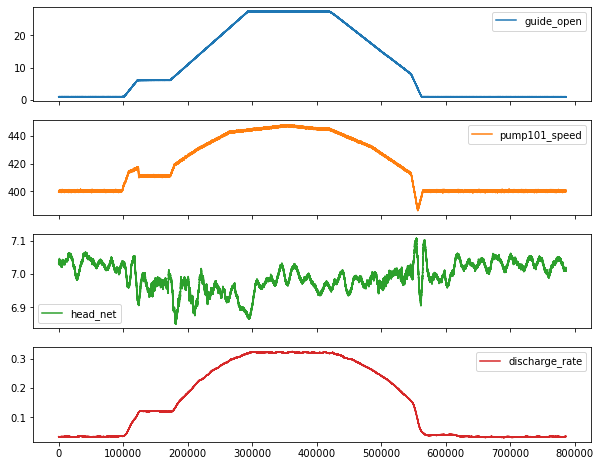

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

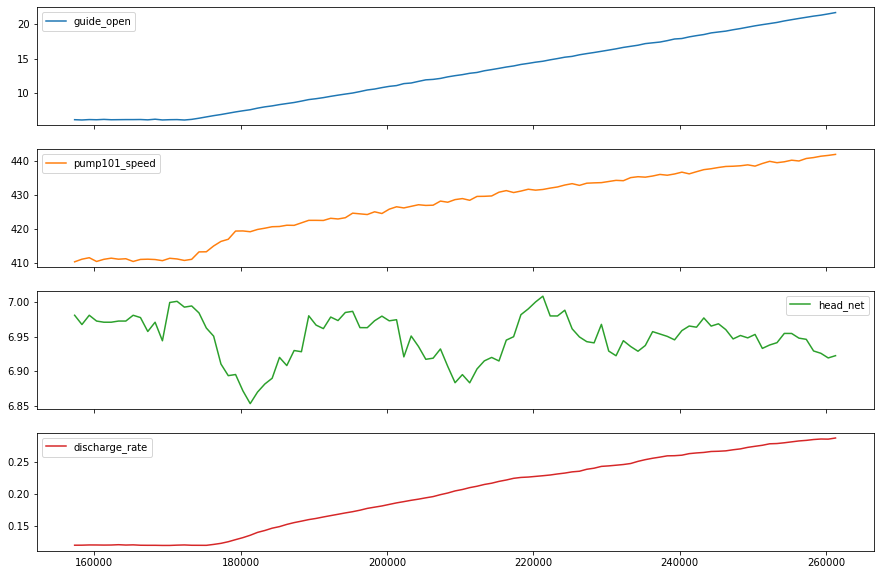

In [3]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True, figsize=(10, 8))
plt.show()

from IPython.display import display, Markdown
#display(Markdown(' <font size="6"><span style="color:blue">**Lets take a close look at the time series.**</span> </font>'))

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

plot_features = df[plot_cols][int(len(df)/5):int(len(df)/3):1000]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True, figsize=(15, 10))

## 2, Preprocessing data: normalize, train, validation, test, etc.

### 2.1, resample the data with low-resolution

<span style="color:red; font-size:30px">**No. of the values in the training dataset is: 1967**</span>

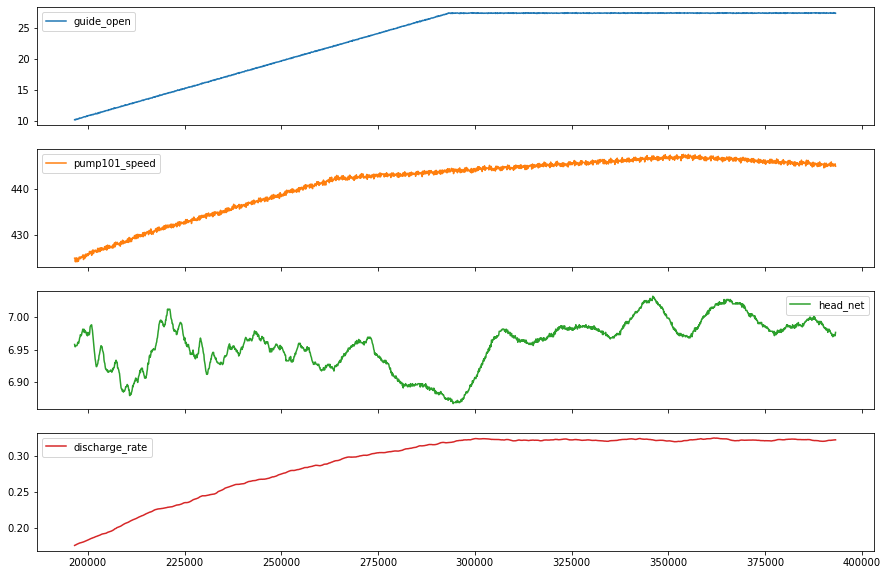

<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>

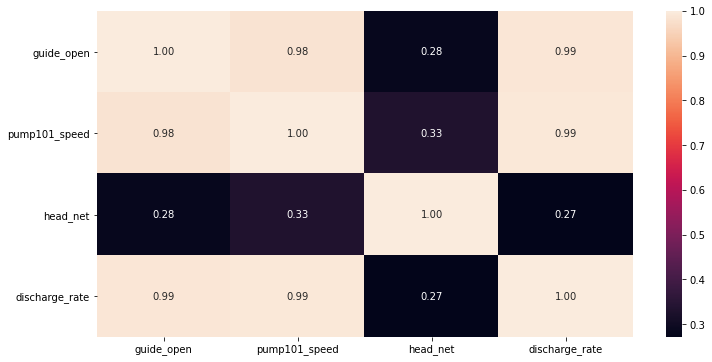

In [4]:
df_train = df[feature_keys[0:7:2]][int(len(df)/4):int(len(df)/2):100]
display(Markdown('<span style="color:red; font-size:30px">**No. of the values in the training dataset is: %d**</span>' %len(df_train)))

# plot the data and check their variations along time
df_train.plot(subplots=True, figsize=(15, 10))
plt.show()
#print('No. of the values in the training dataset is: %d' %len(df_train))

display(Markdown('<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>'))
# check he correlation
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")
plt.show()

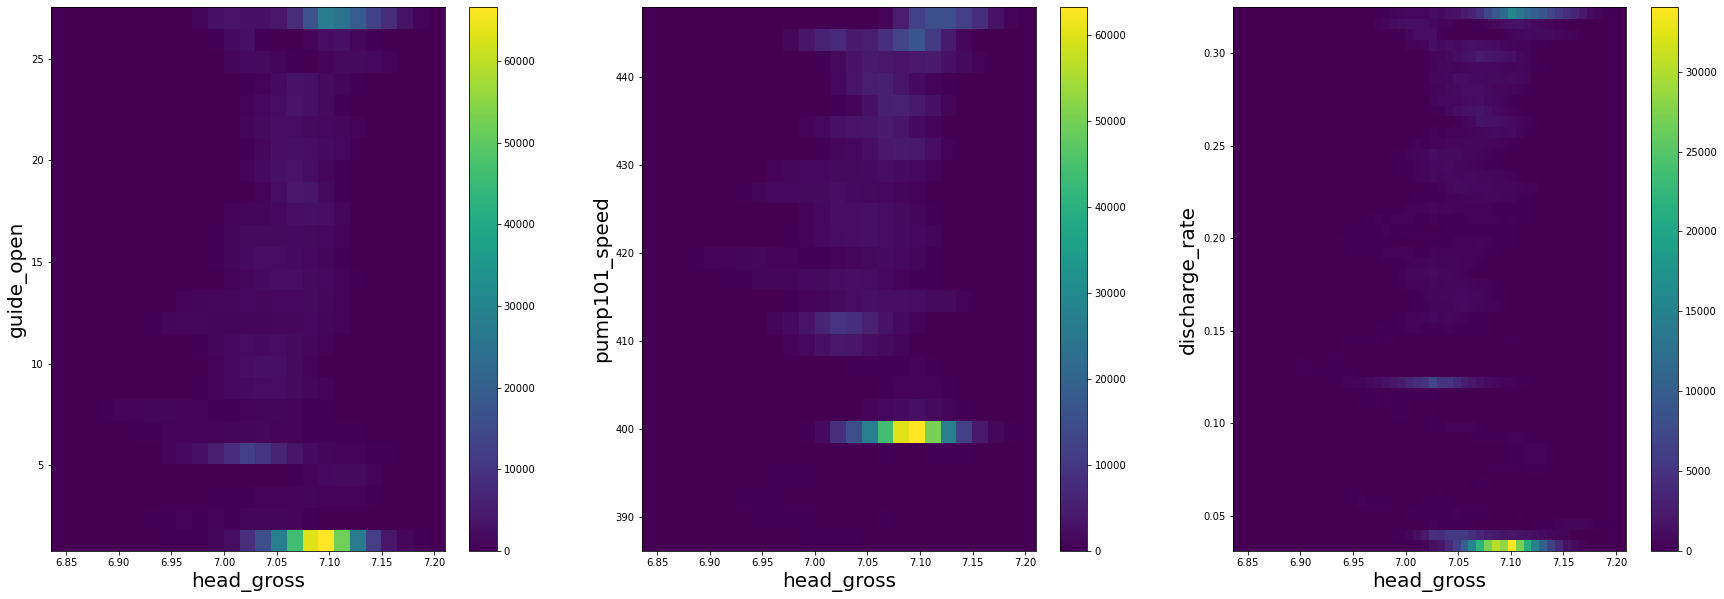

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors, ticker, cm


fig = plt.figure(figsize=(30, 10))
fig.add_subplot(131)
plt.hist2d(df['head_gross'], df['guide_open'], bins=(25, 25))
plt.xlabel('head_gross', size=20)
plt.ylabel('guide_open', size=20)
plt.colorbar()

fig.add_subplot(132)
plt.hist2d(df['head_gross'], df['pump101_speed'], bins=(25, 25))
plt.xlabel('head_gross', size=20)
plt.ylabel('pump101_speed', size=20)
plt.colorbar()

fig.add_subplot(133)
plt.hist2d(df['head_gross'], df['discharge_rate'], bins=(50, 50))
plt.xlabel('head_gross', size=20)
plt.ylabel('discharge_rate', size=20)
plt.colorbar()



In [23]:
features = df.keys()
features

Index(['time', 'guide_open', 'running_speed', 'pump101_speed', 'pump102_speed',
       'pump101_set', 'pump102_set', 'head_net', 'head_gross',
       'discharge_rate', 'unknow_Hg', 'unknow_Hst', 'unknow_Qt',
       'unknown_Pabs'],
      dtype='object')

### 2.2, autocorrelation function (ACF) and (PACF) to check time dependence

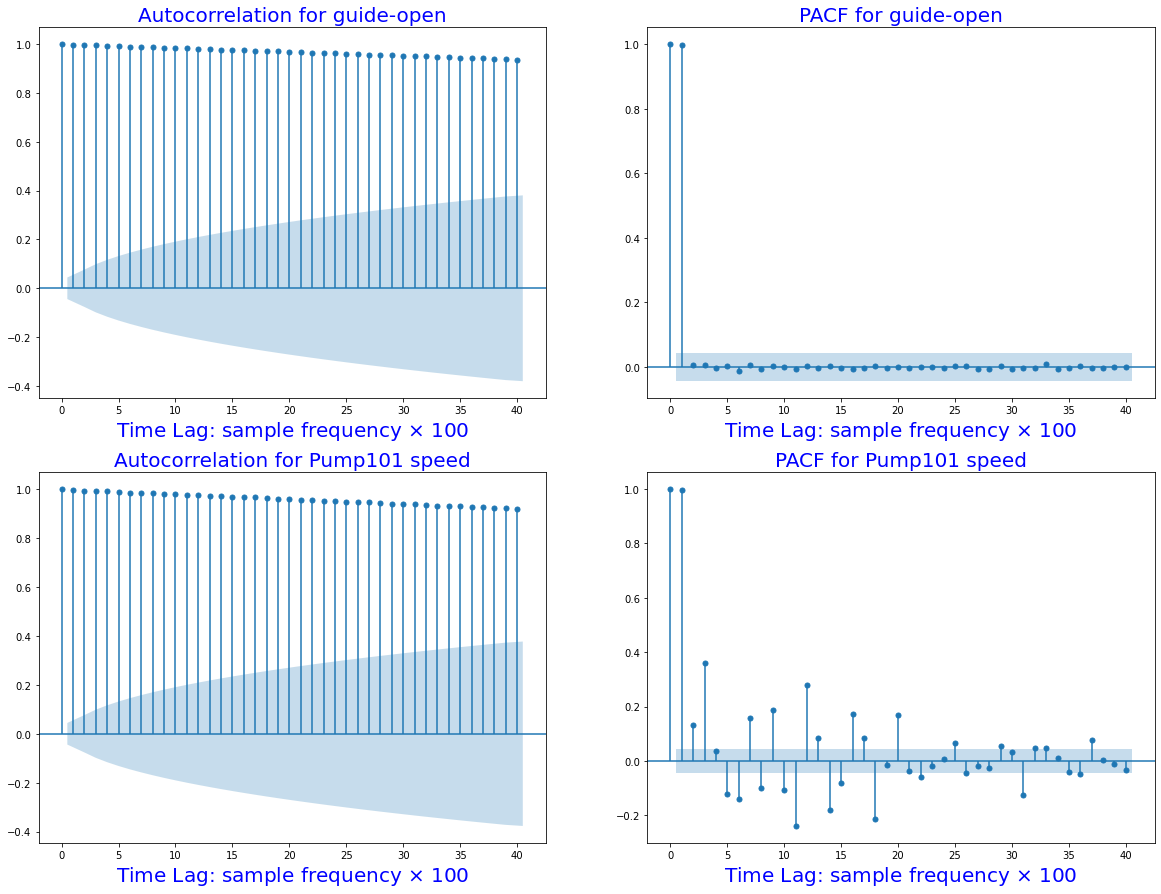

In [101]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

acf_open = autocorr(df_train.guide_open)


from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

fig, ax = plt.subplots(2,2,figsize=(20,15))
sm.graphics.tsa.plot_acf(df_train.guide_open.squeeze(), lags=40, ax=ax[0,0])
ax[0,0].set_title("Autocorrelation for guide-open", fontsize=20, color='blue')
ax[0,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.guide_open.squeeze(), lags=40, ax=ax[0, 1])
ax[0,1].set_title("PACF for guide-open", fontsize=20, color='blue')
ax[0,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_acf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,0])
ax[1,0].set_title("Autocorrelation for Pump101 speed", fontsize=20, color='blue')
ax[1,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,1])
ax[1,1].set_title("PACF for Pump101 speed", fontsize=20, color='blue')
ax[1,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')
plt.show()

### 2.3 crossing autocorrelationship for various parameters

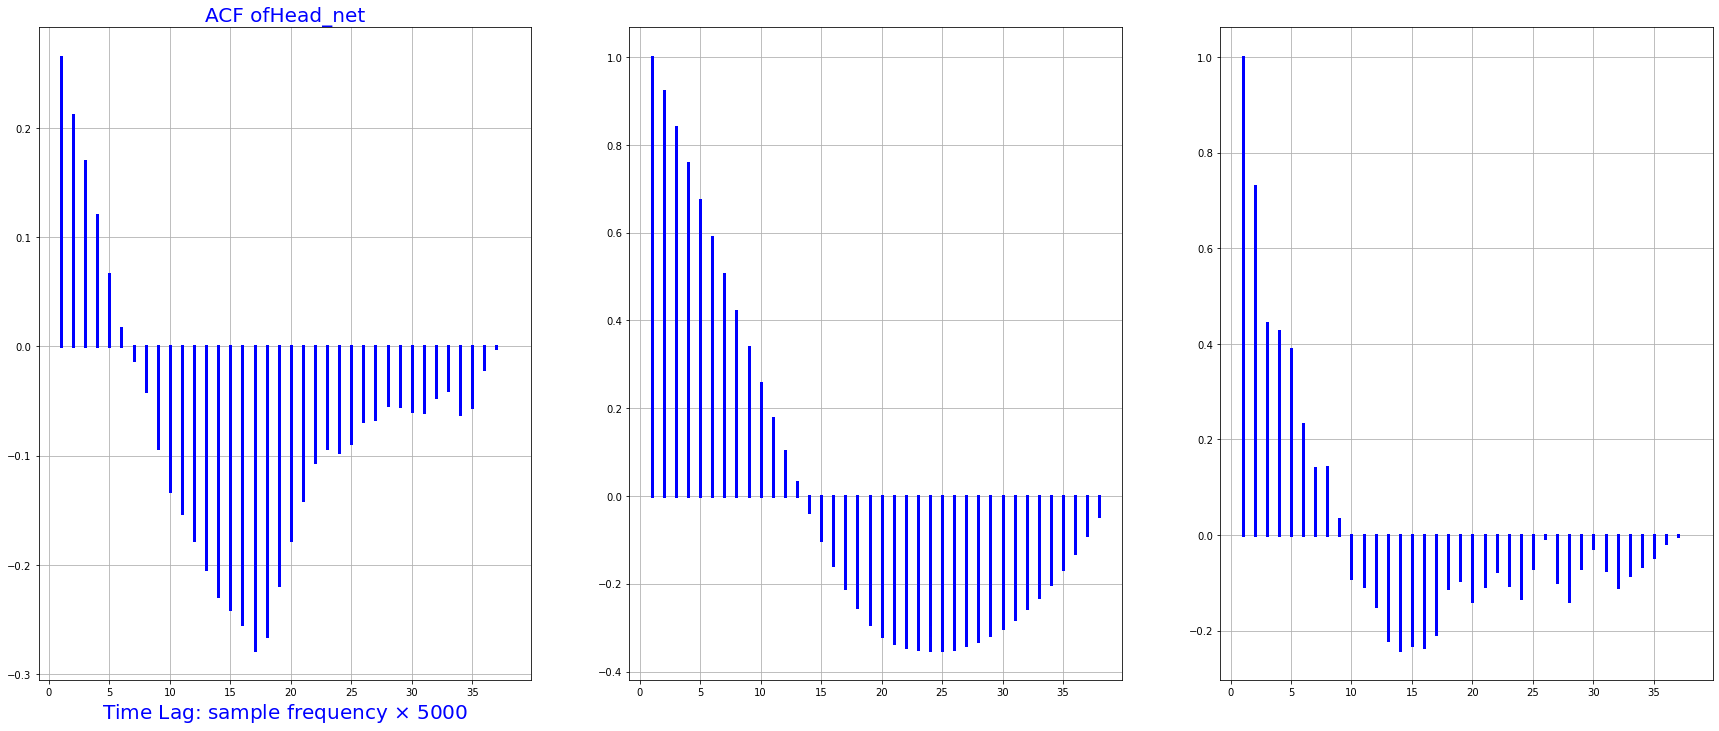

In [151]:
# NB: we have resampled the data for the autocorreltion analysis

import statsmodels.tsa.stattools as smt
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.head_net.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and Head_net", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF ofHead_net", fontsize=20, color='blue')
ax4.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

plt.show()

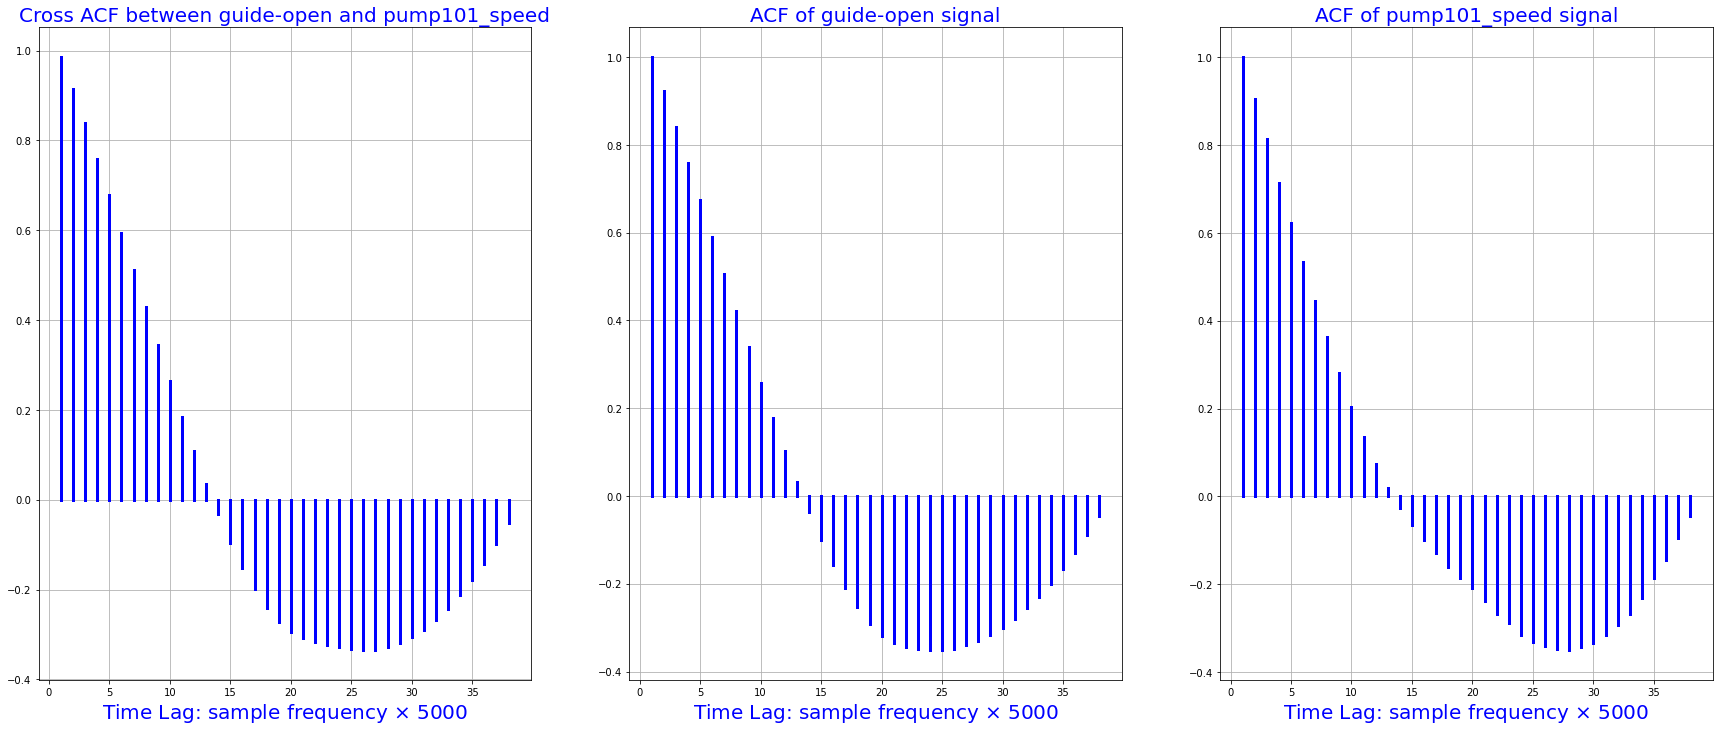

In [152]:
# Autocorrelation between guide_opan and pump101_speed
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.pump101_speed.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and pump101_speed", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF of pump101_speed signal", fontsize=20, color='blue')
ax3.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



plt.show()

### 2.4, normalize the data

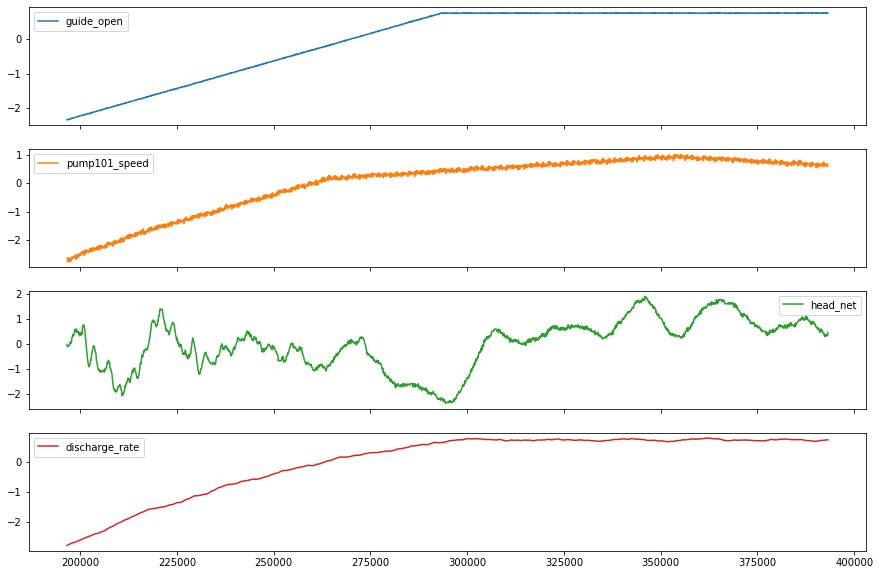

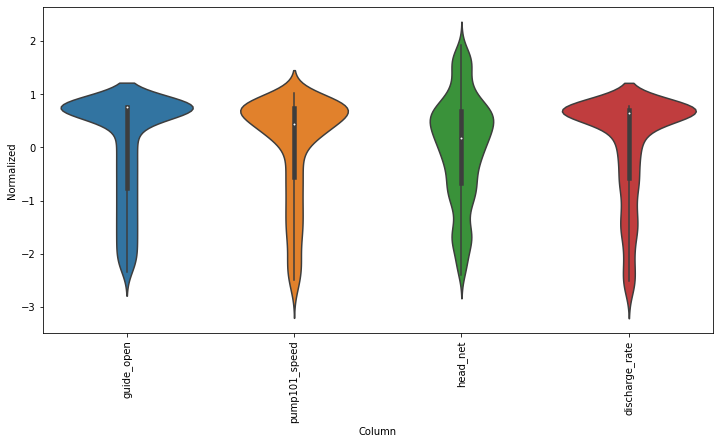

In [15]:
# First, we assume all data are used for the training (the time series is not that stationary for the prediction)
df_train_mean = df_train.mean()
df_train_std = df_train.std()
train_df = (df_train-df_train_mean) / df_train_std

fig2 = train_df.plot(subplots=True,figsize=(15,10))

# Second, plot the standand deviation of features within this dataframe
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(train_df.keys(), rotation=90)

In [42]:
# tf.convert_to_tensor(new_df)
new_df = train_df.reset_index(drop=True)
target = new_df.pop('guide_open')
#new_df.head()
target.head()
new_df = tf.convert_to_tensor(new_df)

#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(numeric_features)

In [43]:
feature_keys

array(['guide_open', 'running_speed', 'pump101_speed', 'pump102_speed',
       'head_net', 'head_gross', 'discharge_rate'], dtype=object)

## 3, RNN deep learning to build the model by three different approaches. 
   **1. normal deep learning network**<br />
   **2. RNN**<br />
   **3. ARIMA model**<br />

### 3.1, First attemp to the model $Head\_net_t = f(guide\_open_{(t-1, t-2, ...)}, pump\_speed_{(t-1, t-2, ...)}, discharge\_rate_{(t-1, t-2, ...)},...)$

In [59]:
df_train = df[feature_keys][int(len(df)/4):int(len(df)/2):100]

df_train = df_train.reset_index(drop=True)
#df_train.pop('time')
df_train.pop('head_net')
df_target = df_train.pop('head_gross')
df_train.head()


,guide_open,running_speed,pump101_speed,pump102_speed,discharge_rate
0,10.258026,883.147506,424.766713,423.792913,0.175680
1,10.220808,883.147506,424.633645,424.918785,0.176028
2,10.313853,882.934738,423.968301,425.084355,0.176227
3,10.302687,883.041122,424.567110,424.422077,0.176376
4,10.354793,883.041122,424.866515,424.157165,0.176774


In [86]:
# Pre-normalize the features for ML analysis
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(df_train)
tf_train = norm(df_train)

# normalize the target (output)
norm_target = tf.keras.layers.Normalization(axis=None)
norm_target.adapt(df_target)
tf_target = norm_target(df_target)

# configure the model
BATCH_SIZE = 500

def get_basic_model():
  model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_basic_model()
model.fit(tf_train, tf_target, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10
4/4 [==============================] - 0s 4ms/step - loss: 231.8849 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: -0.4137 - accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 1.2709 - accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.3186 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 2.9762 - accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 2.1575 - accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 2.1842 - accuracy: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 2.0297 - accuracy: 0.0000e+00
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 1.7910 - accuracy: 0.0000e+00
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 1.3941 - accuracy: 0.0000e

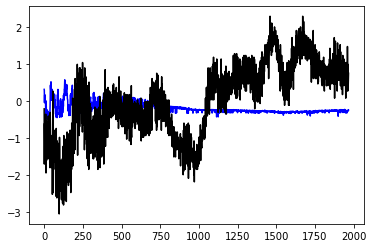

In [88]:
plt.plot(model.predict(df_train),'b')
plt.plot(tf_target,'k')
plt.show()

In [83]:
norm1 = tf.keras.layers.Normalization(axis =-1)
norm1.adapt(df_train)
tf_train = norm1(df_train)

norm2 = tf.keras.layers.Normalization(axis = None)
norm2.adapt(df_target)
tf_target= norm2(df_target)

dataset_df = tf.data.Dataset.from_tensor_slices((tf_train, tf_target))
dataset_batches = dataset_df.shuffle(100).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(dataset_batches, epochs=10)

Epoch 1/10
4/4 [==============================] - 0s 4ms/step - loss: 0.8128 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.5635 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.4945 - accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.4262 - accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.3584 - accuracy: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2882 - accuracy: 0.0000e+00
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2174 - accuracy: 0.0000e+00
Epoch 10/10
4/4 [==============================] - ETA: 0s - loss: -1.1885 - accuracy: 0.0000e+0 - 0

### 3.2, Understand datastructure of the tensorflow package --> formulate rolling windowed dataset --> for model in Section 4

<ipython-input-121-bf96d0c125a6>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 30)


[Text(0, -6.0, '-6.0'),
 Text(0, -4.0, '-4.0'),
 Text(0, -2.0, '-2.0'),
 Text(0, 0.0, '0.0'),
 Text(0, 2.0, '2.0'),
 Text(0, 4.0, '4.0')]

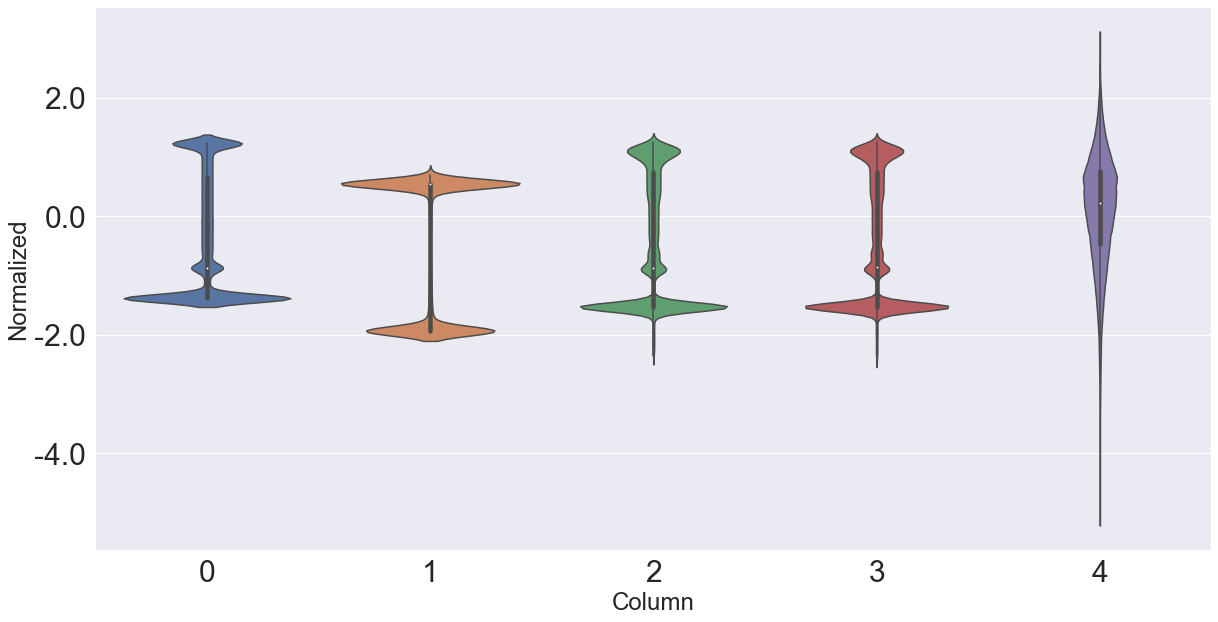

In [121]:
# split the time series of data into train (70%), test (20%) and validation (10%)
#n = len(df_train)
df_train = df[feature_keys]
df_train.pop('head_net')
df_train.pop('discharge_rate')
n = len(df_train)
# start to divide them
train_df = df_train[0:int(n*0.7)]
test_df = df_train[int(n*0.7):int(n*0.9)]
val_df = df_train[int(n*0.9):]
df_train.shape[1]

## Tensorflow dataset donot have buildin functions to estimate the mean and standard deviation
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(train_df)
#train_df = normalizer(train_df)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std

df_std = (df_train - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

fig, ax = plt.subplots(figsize=[20, 10])
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticklabels(ax.get_xticks(), size = 30)
ax.set_yticklabels(ax.get_yticks(), size = 30)

### <span style ="color:blue; font-size:25px"> **3.3, get the rolling/windowed dataset**</span>

In [143]:
# 3.3.1, Indexes and offsets
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# 3.3.2, Split the window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


# 3.3.3, plot the time series
def plot(self, model=None, plot_col='head_gross', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [146]:
# Test of windowed dataset 

w0 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['head_gross'])
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=None)
w=w1

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 5)
Inputs shape: (3, 24, 5)
Labels shape: (3, 1, 5)


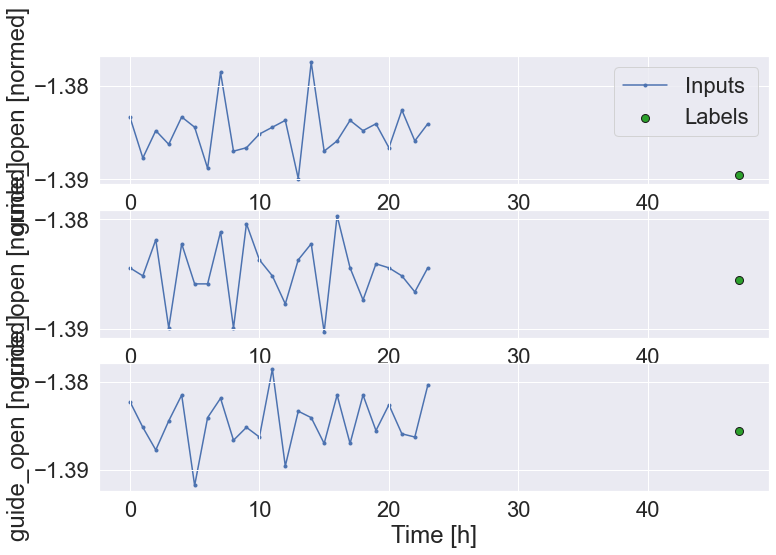

In [148]:
w.example = example_inputs, example_labels
w.plot(plot_col='guide_open')

### <span style ="color:blue; font-size:25px"> **3.4, Create tf.data.Datasets**</span>

In [150]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# add properties to the dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [153]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 1, 5)


## 4, **Preliminary model construction**

### 4.1, single step model (similar as the conventional independent ML methods)

In [158]:
# Get the first dataset
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['head_gross'])
single_step_window

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [89]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Function for creating a windowed dataset for sequence training"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [132]:
series = np.random.normal(0, 1, 19)
series


array([-0.29050317,  0.11212805,  1.25079512, -1.36088997,  0.09993288,
       -0.0479911 , -0.35622969, -1.08855909, -0.3510177 ,  2.58839995,
       -0.50565079, -0.58430921, -1.27309938,  0.74678304, -0.55834612,
       -0.11080156, -1.18733663, -1.00822592, -0.68986173])

In [187]:
data = np.array(train_df.guide_open, dtype=np.float32)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 3
window_size = 80
batch_size = 150
train_set  = windowed_dataset(data, window_size, batch_size, shuffle_buffer_size)
n = 0
for window in train_set:
    n = n +1
    print(window)

display(Markdown('<span style="color:blue; font-size:20px">The windowed size is: %d, and raw datashape is (%d)</span>'%(n, data.shape[0])))

#(f'The windowed size and raw datashape:{n, data.shape}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(<tf.Tensor: shape=(150, 80), dtype=float32, numpy=
array([[-2.3410695, -2.3477952, -2.3309808, ..., -2.0975974, -2.0834734,
        -2.087509 ],
       [-2.3329988, -2.3235826, -2.3329988, ..., -2.0807831, -2.0747302,
        -2.0733848],
       [-2.3477952, -2.3309808, -2.3329988, ..., -2.0834734, -2.087509 ,
        -2.0807831],
       ...,
       [-1.8729576, -1.8695947, -1.8716123, ..., -1.63

<span style="color:blue; font-size:20px">The windowed size is: 13, and raw datashape is (1967)</span>

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    tf.data.Dataset.from_tensor_slices(new_df),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_basic_model()
model.add(new_df.layers[0])
model.fit(tf.data.Dataset.from_tensor_slices(new_df), target, epochs=3, batch_size=BATCH_SIZE)

TypeError: The added layer must be an instance of class Layer. Found: <TensorSliceDataset shapes: (3,), types: tf.float64>

## **4, Model construction**

In [193]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size = 5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation ="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
                                    ])

#input_shape=[None, 1]
#model.build(input_shape)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [184]:
optimizer = tf.keras.optimizers.SGD(lr=1e-3,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer, metrics=["mae"])
history = model.fit(train_set, epochs = 5)

Epoch 1/5


ValueError: in user code:

    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, None]
